# Sequential probability ratio test for simple random samples

We use the sequential testing procedure from Weiss (1962). To test the null hypothesis that a multinomial random variable has equal category probabilities $1/k$, we instead conduct a binomial SPRT for modified hypotheses. Fix some integer $s<k$ and let $p_0 = s/k$. Let $p$ denote the probability that the sample is from one of the $s$ most frequent categories. We test

$$H_0: p = p_0 \text{ against } H_1: p = p_1 > p_0.$$

After the $N$th draw from the distribution, we determine which $s$ categories occurred most frequently among the first $N-1$ draws. We say that the event occurs if the $N$th draw is among these categories.


## Simulation parameters

We compare three PRNGs (Mersenne Twister, Super Duper LCG, and SHA-256) and two sampling algorithms (PIKK and sampling by index). Throughout, we use a population of size $n=13$ and draw samples of size $k=3$, for a total of ${13 \choose 3} = 286$ possible multinomial categories. We set $s=10$ and specify $p_1 = 1.1p_0$. We use a type I error rate of $\alpha=0.05$ and type II error rate of $\beta = 0$; this ensures that we never accept the null hypothesis, but either reject it at level $\alpha$ or terminate after $10^7$ steps without making a decision.

## Summary of results

Out of 1000 seeds, we only rejected the null hypothesis roughly $5\%$ of the time, for all of the PRNG and algorithm combinations. The rejection rate was highest for Super Duper, then Mersenne Twister, and was lowest for SHA-256, though the differences between the PRNGs were not large. The rejection rate for PIKK tended to be slightly higher than for sampling by index.

We subsetted to the tests which terminated with a decision to reject the null hypothesis of equal sample frequencies and compared the number of steps before termination for each PRNG and sampling algorithm combination. The test tended to reject the null for Super Duper after fewer steps than the other PRNGs and tended to require the most steps to reject the null for Mersenne Twister. On average, the tests involving PIKK terminated sooner than those sampling by index.

In [1]:
library(dplyr)
library(ggplot2)
options(warn = (-1), message = (-1))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
combinations <- expand.grid(c("MT", "SD", "SHA256"),
                            c("PIKK", "sbi"))

rawdatafiles <- list.files("../rawdata/")

res <- lapply(1:nrow(combinations), function(index){
  filename <- paste0(combinations[index, 1],
                     "_multinomial_", combinations[index, 2], ".csv")
  if(!(filename %in% rawdatafiles)){ return()}
  
  tmp <- read.csv(paste0("../rawdata/", filename), header = TRUE)
  tmp$PRNG <- rep(combinations[index, 1], nrow(tmp))
  tmp$algorithm <- rep(combinations[index, 2], nrow(tmp))
  return(tmp)
})
res <- do.call(rbind, res)

In [3]:
head(res)
str(res)

prng,algorithm,seed,decision,LR,pvalue,steps,n,k,s,PRNG
MT,PIKK,739828299,None,6.916919e-322,1.0000000,10000000,13,3,10,MT
MT,PIKK,3802979302,None,7.312172e-322,1.0000000,10000000,13,3,10,MT
MT,PIKK,2488119888,None,8.300303e-322,1.0000000,10000000,13,3,10,MT
MT,PIKK,2813529707,None,6.818106e-322,1.0000000,10000000,13,3,10,MT
MT,PIKK,564698376,1,2.117783e+01,0.0472192,7200,13,3,10,MT
MT,PIKK,2114313936,None,6.981148e-321,1.0000000,10000000,13,3,10,MT


'data.frame':	6000 obs. of  11 variables:
 $ prng     : Factor w/ 3 levels "MT","SD","SHA256": 1 1 1 1 1 1 1 1 1 1 ...
 $ algorithm: Factor w/ 2 levels "PIKK","sbi": 1 1 1 1 1 1 1 1 1 1 ...
 $ seed     : num  7.40e+08 3.80e+09 2.49e+09 2.81e+09 5.65e+08 ...
 $ decision : Factor w/ 2 levels "1","None": 2 2 2 2 1 2 2 2 2 2 ...
 $ LR       : num  6.92e-322 7.31e-322 8.30e-322 6.82e-322 2.12e+01 ...
 $ pvalue   : num  1 1 1 1 0.0472 ...
 $ steps    : int  10000000 10000000 10000000 10000000 7200 10000000 10000000 10000000 10000000 10000000 ...
 $ n        : int  13 13 13 13 13 13 13 13 13 13 ...
 $ k        : int  3 3 3 3 3 3 3 3 3 3 ...
 $ s        : int  10 10 10 10 10 10 10 10 10 10 ...
 $ PRNG     : Factor w/ 3 levels "MT","SD","SHA256": 1 1 1 1 1 1 1 1 1 1 ...


In [4]:
res %>% group_by(PRNG, algorithm) %>% summarise("Rejection rate" = mean(decision == "1"))

PRNG,algorithm,Rejection rate
MT,PIKK,0.044
MT,sbi,0.038
SD,PIKK,0.049
SD,sbi,0.053
SHA256,PIKK,0.037
SHA256,sbi,0.032


In [10]:
rejects <- res %>% filter(decision != "None")
rejects %>% group_by(PRNG, algorithm) %>% summarise("Mean steps" = mean(steps),
                                                    "Median steps" = median(steps),
                                                    "Min steps" = min(steps),
                                                    "Max steps" = max(steps))

PRNG,algorithm,Mean steps,Median steps,Min steps,Max steps
MT,PIKK,19768.84,16088.5,3284,83973
MT,sbi,22439.21,16789.0,3362,129396
SD,PIKK,15251.78,10777.0,3794,57027
SD,sbi,16527.43,12667.0,1055,87865
SHA256,PIKK,16141.38,13860.0,3039,48938
SHA256,sbi,16837.44,13014.5,5047,74842


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


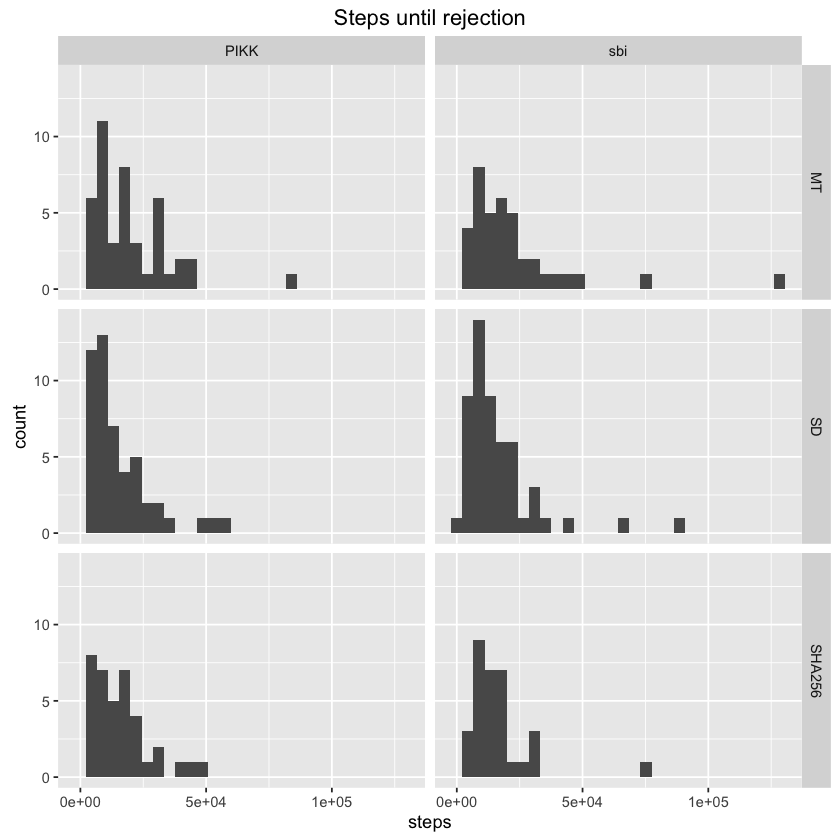

In [6]:
rejects %>% 
    ggplot(aes(steps)) + 
    geom_histogram() + 
    facet_grid(PRNG~algorithm) +
    ggtitle("Steps until rejection")